Create datasets and data frames, plan out strategy

Aim: single channel eye blink detection for channel not proximal to eyes (Cz)

Steps:
1. Break down into test, val and validation sets (3, 13, 3) DONE
Filter data? Optional
Scale data Optional --> done in PCA
2. Epoch data DONE
3. Label test and validation sets and few val sets (3, 3, 3). Label using Fp1 data DONE
4. Create features to be used for data analysis from all the training and validation datasets DONE
5. Check if PCA or others reveal any redundant features and reduce dimensions DONE
6. Focus on training sets, run K means and random forest in unsupervised method and tune with labels


3 methods:
1. kmeans: features DONE
2. kmeans: pca DONE
3. kmeans: dtw, raw time series -> Raw time series takes too long with my computing power
4. Maybe hierarchial clustering, random forest, DBSCAN

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from MLModelHelper import createFeatures

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
import joblib
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from dtaidistance import dtw
from tslearn.clustering import TimeSeriesKMeans


In [2]:
Fs = 256

#Load dataframes, convert back to numpy for simpler feature generation
Cz_train_US = pd.read_csv (r'Cz_train_US_df.csv', header=0).to_numpy()
Cz_train_S = pd.read_csv (r'Cz_train_S_df.csv', header=0).to_numpy()
Cz_val = pd.read_csv (r'Cz_val_df.csv', header=0).to_numpy()

Cz_train_S_Labels = pd.read_csv (r'Cz_train_S_Labels.csv', header=0).to_numpy().ravel()
Cz_val_Labels = pd.read_csv (r'Cz_val_Labels.csv', header=0).to_numpy().ravel()
print(Cz_train_S_Labels.shape)

Cz_train = np.append(Cz_train_S,Cz_train_US, axis=0) #combine all training features
print(Cz_train.shape)


(1800,)
(7800, 128)


Will capture features relating to waveform shape and frequency



In [3]:

[feature_names, Cz_train_US_features] = createFeatures(Cz_train_US, Fs)
[feature_names, Cz_train_S_features] = createFeatures(Cz_train_S, Fs)

Cz_train_features = np.append(Cz_train_S_features,Cz_train_US_features, axis=0)
print(Cz_train_features.shape)

(7800, 13)


PCA

In [19]:
# scaled_Cz_train = StandardScaler().fit_transform(Cz_train_features)

feature_scaler = StandardScaler().fit(Cz_train_features)
scaled_Cz_train = feature_scaler.transform(Cz_train_features)

pca_trained = PCA(n_components = 2)
Cz_train_PC = pca_trained.fit_transform(scaled_Cz_train)

explained_variance = pca_trained.explained_variance_ratio_ 
print(explained_variance)

[0.34241645 0.18950257]


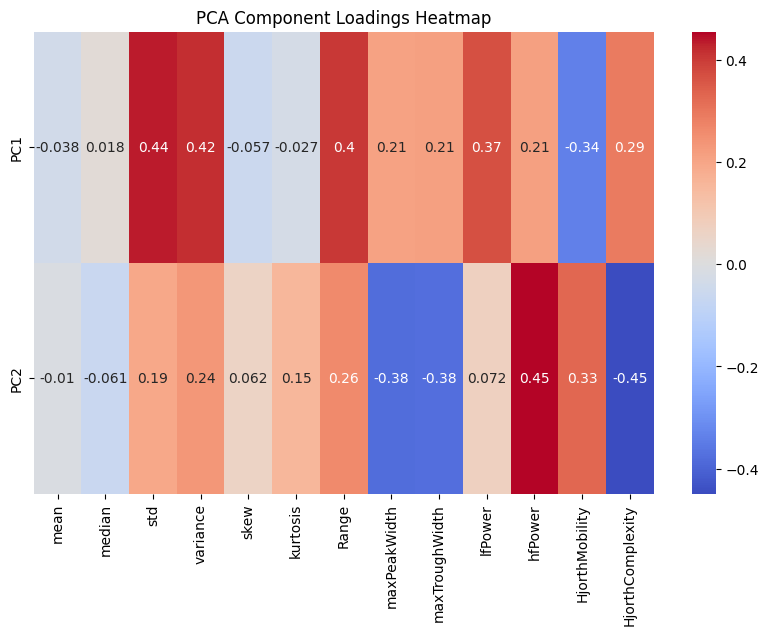

In [5]:
loadings = pd.DataFrame(pca_trained.components_, columns=feature_names, index=[f'PC{i+1}' for i in range(pca_trained.n_components_)])

plt.figure(figsize=(10, 6))
sns.heatmap(loadings, cmap='coolwarm', annot=True)
plt.title('PCA Component Loadings Heatmap')
plt.show()

In [6]:
#separate supervised and unsupervised

Cz_train_S_PC = Cz_train_PC[0:1800,:]
Cz_train_US_PC = Cz_train_PC[1800:,:]


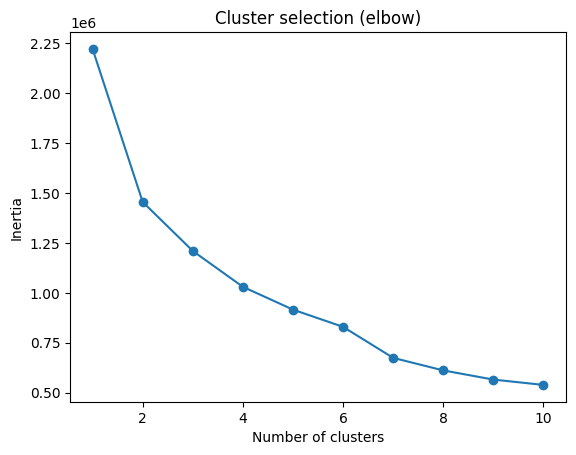

In [7]:
#Test feature kmeans using elbow method
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=8)
    kmeans.fit(Cz_train_features)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Cluster selection (elbow)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Adjusted Rand Index: 0.129
Normalized Mutual Information: 0.078
Accuracy: 0.6916666666666667
Cluster-label-mapped accuracy: 0.793


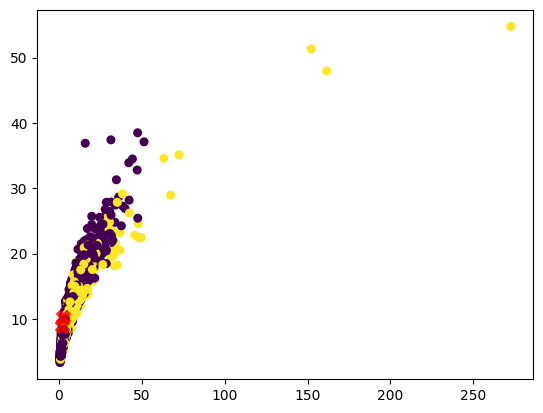

In [8]:
kmeans = KMeans(n_clusters=2, random_state=8)
kmeans.fit(Cz_train_features)

Cz_train_S_predictions = kmeans.predict(Cz_train_S_features)

#test how well the kmeans predictions are
ari = adjusted_rand_score(Cz_train_S_Labels, Cz_train_S_predictions)
nmi = normalized_mutual_info_score(Cz_train_S_Labels, Cz_train_S_predictions)

print(f'Adjusted Rand Index: {ari:.3f}')
print(f'Normalized Mutual Information: {nmi:.3f}')


conf_mat = confusion_matrix(Cz_train_S_Labels, Cz_train_S_predictions)

print("Accuracy:",metrics.accuracy_score(Cz_train_S_Labels, Cz_train_S_predictions))

mapping = {}
for cluster_idx in range(conf_mat.shape[1]):
    true_label = np.argmax(conf_mat[:, cluster_idx])
    mapping[cluster_idx] = true_label


mapped_labels = np.vectorize(mapping.get)(Cz_train_S_predictions)

# 6. Evaluate mapped clustering as classification predictions
acc = accuracy_score(Cz_train_S_Labels, mapped_labels)
print(f'Cluster-label-mapped accuracy: {acc:.3f}')

centroids = kmeans.cluster_centers_
plt.scatter(Cz_train_features[:, 3],Cz_train_features[:, 6],  c=kmeans.labels_, s=30, cmap='viridis')
plt.scatter(centroids[:, 2], centroids[:, 6], c='red', s=100, alpha=0.75, marker='X')

plt.show()




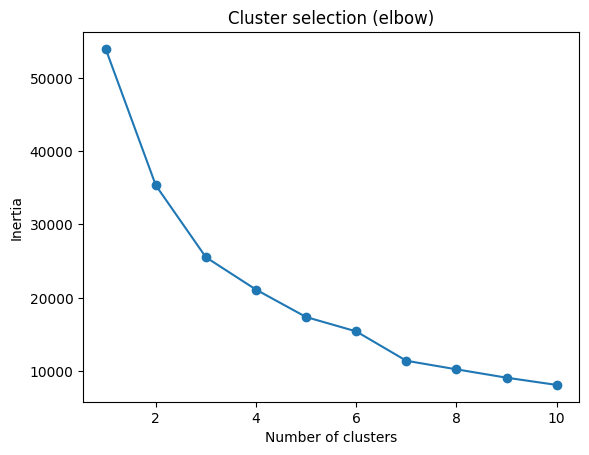

In [9]:
#Test feature kmeans using elbow method
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=8)
    kmeans.fit(Cz_train_PC)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Cluster selection (elbow)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Adjusted Rand Index: 0.331
Normalized Mutual Information: 0.204
Accuracy: 0.805
Cluster-label-mapped accuracy: 0.805


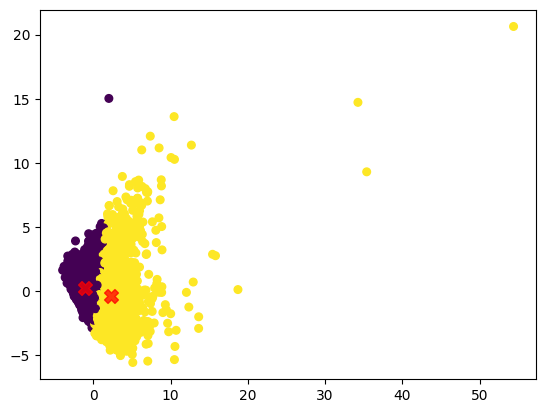

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=8)
kmeans.fit(Cz_train_PC)

Cz_train_S_predictions = kmeans.predict(Cz_train_S_PC)

#test how well the kmeans predictions are
ari = adjusted_rand_score(Cz_train_S_Labels, Cz_train_S_predictions)
nmi = normalized_mutual_info_score(Cz_train_S_Labels, Cz_train_S_predictions)

print(f'Adjusted Rand Index: {ari:.3f}')
print(f'Normalized Mutual Information: {nmi:.3f}')

conf_mat = confusion_matrix(Cz_train_S_Labels, Cz_train_S_predictions)

print("Accuracy:",accuracy_score(Cz_train_S_Labels, Cz_train_S_predictions))

mapping = {}
for cluster_idx in range(conf_mat.shape[1]):
    true_label = np.argmax(conf_mat[:, cluster_idx])
    mapping[cluster_idx] = true_label


mapped_labels = np.vectorize(mapping.get)(Cz_train_S_predictions)

# 6. Evaluate mapped clustering as classification predictions
acc = accuracy_score(Cz_train_S_Labels, mapped_labels)
print(f'Cluster-label-mapped accuracy: {acc:.3f}')

centroids = kmeans.cluster_centers_
plt.scatter(Cz_train_PC[:, 0],Cz_train_PC[:, 1],  c=kmeans.labels_, s=30, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, alpha=0.75, marker='X')

plt.show()


In [11]:
Cz_train_US_predictions = kmeans.predict(Cz_train_US_PC)
mapped_labels = np.vectorize(mapping.get)(Cz_train_US_predictions).reshape(Cz_train_US_predictions.shape[0],1)
print(mapped_labels.shape)
print(Cz_train_US.shape)

repeated_mapped_labels = np.tile(mapped_labels, (1,128))
print(repeated_mapped_labels.shape)

Cz_train_US_joined = Cz_train_US.reshape(-1)
mapped_labels_joined = repeated_mapped_labels.reshape(-1)
print(Cz_train_US_joined.shape)
print(mapped_labels_joined.shape)


(6000, 1)
(6000, 128)
(6000, 128)
(768000,)
(768000,)


<Axes: xlabel='time', ylabel='value'>

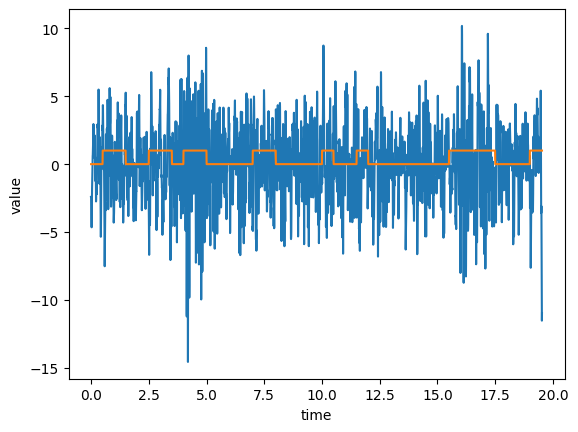

In [12]:
timePts = 5000

timeSec = np.arange(timePts)*(1/Fs)
Cz_train_US_joined_df =  pd.DataFrame({'time': timeSec, 'value': Cz_train_US_joined[:timePts], 'mapped_label': mapped_labels_joined[:timePts]})

sns.lineplot(data=Cz_train_US_joined_df,x= 'time', y='value')
sns.lineplot(data=Cz_train_US_joined_df,x= 'time', y='mapped_label')



In [ ]:
# # 128 features (each data point) Hence takes too long
# tskmeans = TimeSeriesKMeans(n_clusters=2, metric="dtw", random_state=8)
# # Fit the model
# tskmeans.fit(Cz_train)

Better model seems to be with PCA,
Check validation accuracy:

In [24]:
[feature_names, Cz_val_features] = createFeatures(Cz_val, Fs)
Cz_val_scaled = feature_scaler.transform(Cz_val_features)
Cz_val_PC = pca_trained.transform(Cz_val_scaled)

Cz_val_predictions = kmeans.predict(Cz_val_PC)
val_mapped_labels = np.vectorize(mapping.get)(Cz_val_predictions).reshape(Cz_val_predictions.shape[0],1)

print("Accuracy:", accuracy_score(Cz_val_Labels, val_mapped_labels))
print("F1 score:", f1_score(Cz_val_Labels, val_mapped_labels, average=None))
print("Precision", precision_score(Cz_val_Labels, val_mapped_labels, average=None))
print("Recall:", recall_score(Cz_val_Labels, val_mapped_labels, average=None))

Accuracy: 0.8427777777777777
F1 score: [0.89251804 0.7073423 ]
Precision [0.93032462 0.63687151]
Recall: [0.85766423 0.79534884]
